## Finance Review:

### Introduction to Portfolio Theory 

People invest their money for different reasons. Some simply invest to maintain their hard-earned money and to beat inflation, others invest to achieve immense long term growth in capital and others invest because they believe in what they're investing in and want to grow with it. Generally, it is said that a good investment portfolio (or collection of assets) is one that generates high returns with low risk. Mathematically, under the assumption that markets are efficient, one can describe an optimal portfolio as the following:

Say one has a portfolio $P$ with $n$ assets in it. The portfolio can be represented as a vector $$\vec{P} = [w_1,w_2, w_3, \dots, w_n]$$

Where $w_i \in (0,1)$ represents the weight of the $i$-th asset, meaning that the sum of all elements in $P$ must equal 1. 

Because we're assuming that markets are efficient, and that past performance is indicitive of future results, we can then describe how much return an asset $i$ is expected to give by the average return in a given period (e.g the average annual return for the past 5 years). Similarly, the risk can be described by the <a href="https://en.wikipedia.org/wiki/Covariance_matrix">covariance matrix</a> of the assets in the portfolio, making this a typical mean-variance problem


### Portfolio Optimization


Suppose an investment firm has a collection of $n$ stocks and want to construct a portfolio out of them, but are not sure how to distribute capital amongst these stocks. As stated before, their goal should be to maximize potential profit (mean return) while minimizing risk (variance/standard deviation). An (overly) simplistic model is to set up the following quadratic optimization problem to maximize potential profit while minimizing risk:

Say we have a covariance matrix $C$ and an undecided portfolio $\vec{P}$, the goal is to mimimize risk, $\sigma$

$$\sigma = \frac{1}{2}\vec{P}^T C \vec{P}$$

However, minimizing this risk could potentially destroy profits, so we must set a linear constraint to be the expected return $\rho$, where

$$\rho = \sum_{i=1}^{n} m_iw_i$$

where $\rho$ is the periodic return of the portfolio, $m_i$ is the periodic return of the $i$-th asset and $w_i$ is the weight of the $i$-th asset. 

With this method, we are encoding both potential risk and potential reward into the objective function and the constraint respectively. A metric usually used to describe how _good_ a portfolio is is called the Sharpe Ratio, or 

$$S_a = \frac{(R_a - R_b)}{\sigma_a}$$

where $S_a$ is the Sharpe Ratio, $R_a$ is the return of the portfolio, $R_b$ is the risk free return (i.e the return you would've gotten by putting your money in something risk free, like Treasury Bills) and $\sigma_a$, the standard deviation of the portfolio. The higher the Sharpe Ratio, the better. 

### Example: 3 Stock Portfolio

Say you have some funds that you would like to distribute between Apple ($\$$AAPL), Berkshire Hathaway ($\$$BRK.B) and Tesla ($\$$TSLA), and that you aim on obtaining an average annual return no less than 35\%. Using the data from the past 5 years, you get the following results:

The covariance matrix $C$:


<img src="https://haqai.s3.us-east-2.amazonaws.com/problemimages/covmat.jpg" width="330px">


and the average annual return of each stock, 

                                                    $AAPL: 40.0% 
                                                $BRK.B: 15.1%
                                                    $TSLA: 76.1%



which, by replacing AAPL, BRK.B and TSLA with the indices 1,2,3 respectively, we can arrange into a vector, $\vec{m} = [0.400, 0.151, 0.761]$.

This is enough data to optimize the portfolio $P = [w_1,w_2,w_3]$ with the following quadratic program:



Minimize 
$$\frac{1}{2} \vec{P}^T \begin{pmatrix}0.091279	& 0.034477 &0.073135 \\ 0.034477 & 0.046043 & 0.032000 \\ 0.073135 & 0.032000 & 0.351173\end{pmatrix} \vec{P}$$

With three continuous variables: $w_1$, $w_2$ and $w_3$ 

And two linear constraints:

1. 

$$\sum_{i=1}^3 w_i = w_1 + w_2 + w_3 = 1$$


2.$$\vec{P}.\vec{m} \geq 0.35$$


In simpler terms, constraint 1 states that the sum of all weighs should be 1 (one hundred percent) and constraint 2 states that the total return, which for obvious reasons is the dot product between the portfolio vector and the annual returns vector, should be no less than 35\%. 

By solving this optimization problem (using one method or another), one could get some ideally allocated portfolio (according to those metrics, which, by the way, on there own, are terrible). In this case, it's $\vec{P} = [0.70214, 0.0, 0.29786]$, which yields a Sharpe Ratio of 1.51, three times higher than the SP500.
                                       
           

## Our Task 

Design a Quantum Algorithm which optimizes a FAANG portfolio!

**Note:** The variables that represent the asset weighs should be called "FB", "AMZN", "AAPL", "NFLX" and "GOOG" (in that order).
<br>
<br>

The input data represents FAANG stock daily changes from the September 13, 2017 to September 13, 2021 and is represented by a Pandas <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html">DataFrame() </a>object named ```returns_data```. Namely,

<img src="https://haqai.s3.us-east-2.amazonaws.com/problemimages/dataframe.jpg" width="350px">

### Import all stuff 

In [88]:
from pandas_datareader import data as web
import pandas as pd
import numpy as np
from datetime import datetime
from qiskit_optimization import QuadraticProgram
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np


def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(opt_faang).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))

### Step 1: Defining the problem

In [48]:
#List of FAANG stock tickers
assets = ['FB', 'AMZN', 'AAPL', 'NFLX','GOOG']

returns_data = pd.DataFrame()

for stock in assets:
    returns_data[stock] = web.DataReader(stock, data_source='yahoo', start='2017-09-13', end='2021-09-13')['Adj Close'].pct_change()[1:-1]
    

## Begin Code

cov = returns_data.cov()*252
aar = [np.array(returns_data[stock]).sum()/4 for stock in assets]

opt_faang = QuadraticProgram(name="FAANG Optimize")


opt_faang.binary_var(name="FB")
opt_faang.binary_var(name="AMZN")
opt_faang.binary_var(name="AAPL")
opt_faang.binary_var(name="NFLX")
opt_faang.binary_var(name="GOOG") 
opt_faang.minimize(quadratic = np.array(cov)/2)

opt_faang.linear_constraint(linear={"FB": 1, "AMZN": 1,"AAPL": 1,"NFLX": 1,"GOOG": 1}, sense="==", rhs=3)


## End Code

### Final Product:

In [49]:
opt_faang

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: FAANG Optimize

Minimize
 obj: [ 0.125791118626 FB^2 + 0.138638841885 FB*AMZN + 0.141611148245 FB*AAPL
      + 0.142899513993 FB*NFLX + 0.141664269583 FB*GOOG + 0.098901934149 AMZN^2
      + 0.131714012122 AMZN*AAPL + 0.161394067907 AMZN*NFLX
      + 0.121567862493 AMZN*GOOG + 0.106470847383 AAPL^2
      + 0.130189150546 AAPL*NFLX + 0.126632829205 AAPL*GOOG
      + 0.161826927993 NFLX^2 + 0.124652940435 NFLX*GOOG + 0.082967343063 GOOG^2
      ]/2
Subject To
 c0: FB + AMZN + AAPL + NFLX + GOOG = 3

Bounds
 0 <= FB <= 1
 0 <= AMZN <= 1
 0 <= AAPL <= 1
 0 <= NFLX <= 1
 0 <= GOOG <= 1

Binaries
 FB AMZN AAPL NFLX GOOG
End

### Step 2: Setting up the solver (QAOA)

In [83]:
from qiskit.utils import algorithm_globals
from qiskit import Aer

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")
seed = 123
num_assets = len(assets)
cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(opt_faang)



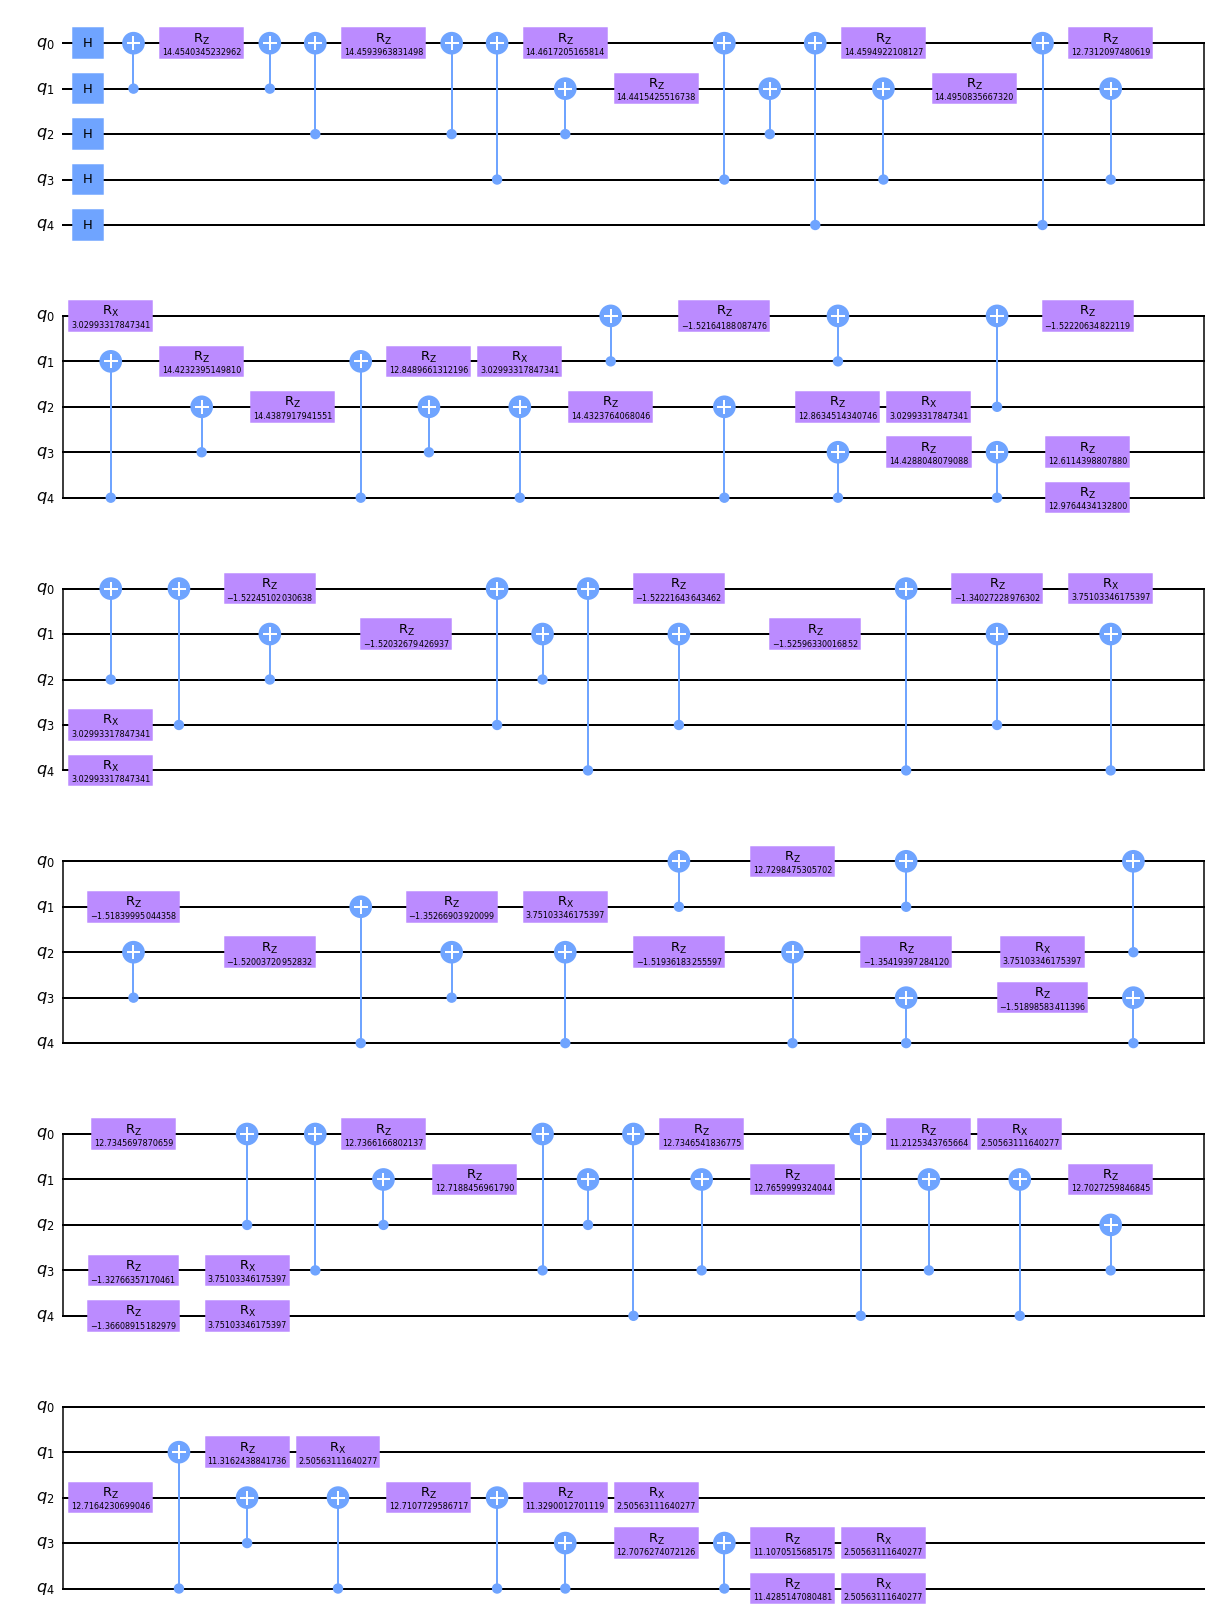

In [96]:
qaoa_mes.get_optimal_circuit().draw('mpl') #optimal circuit

In [97]:
print_result(result) #result 

Optimal: selection [0. 1. 1. 0. 1.], value 0.3341

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 0 1 1 0]	0.4044		0.0973
[1 1 0 1 0]	0.4147		0.0933
[1 0 0 1 1]	0.3899		0.0893
[0 1 1 1 0]	0.3952		0.0872
[1 1 1 0 0]	0.3716		0.0859
[0 0 1 1 1]	0.3664		0.0858
[0 1 0 1 1]	0.3757		0.0839
[1 1 0 0 1]	0.3548		0.0811
[0 1 1 0 1]	0.3341		0.0774
[1 0 1 0 1]	0.3626		0.0741
[1 0 0 1 0]	2.1837		0.0165
[1 0 1 1 1]	2.6108		0.0114
[0 0 1 1 0]	2.1677		0.0104
[0 1 1 1 1]	2.5916		0.0099
[1 1 1 1 0]	2.6382		0.0098
[1 1 0 0 0]	2.1501		0.0096
[0 1 0 1 0]	2.1795		0.0096
[1 1 0 1 1]	2.6186		0.0093
[0 0 0 1 1]	2.1532		0.0075
[1 1 1 0 1]	2.5764		0.0072
[0 0 0 0 0]	17.7162		0.0067
[1 0 1 0 0]	2.1554		0.0064
[0 1 1 0 0]	2.1370		0.0050
[0 0 0 0 1]	7.9153		0.0040
[1 0 0 0 1]	2.1437		0.0040
[1 1 1 1 1]	8.8423		0.0034
[0 1 0 0 1]	2.1202		0.0034
[0 0 1 0 0]	7.9271		0.0030
[0 1 0 0 0]	7.9233		0.0026
[0 0 1 0 1]	2.1265		0.0018
[1 0 

### References and Further Reading:

